In [0]:
!unzip test_Bh8pGW3.zip
!unzip train_DETg9GD.zip

In [6]:
import numpy as np
import pandas as pd
from random import randint
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import imread
from pylab import *
from albumentations import (RGBShift,Blur,RandomContrast,HueSaturationValue,RandomGamma,Rotate,RandomBrightness,HorizontalFlip, Normalize, Resize, Compose, GaussNoise,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
!pip install timm
import timm
import rangelars_lookahead_ralamb
from rangelars_lookahead_ralamb import *

In [0]:
train_csv = pd.read_csv('/content/train.csv')
train_csv,val_csv = train_test_split(train_csv,test_size=0.06,random_state=8)
test_csv = pd.read_csv('/content/test.csv')
test_csv['Class']=""
test_csv.Class='MIDDLE'

In [8]:
print('train image count--',len(train_csv),'\t test image count--',len(test_csv),'\t val image count--',len(val_csv))
train_csv.Class.value_counts(normalize=True)

train image count-- 18711 	 test image count-- 6636 	 val image count-- 1195


MIDDLE    0.543103
YOUNG     0.336112
OLD       0.120785
Name: Class, dtype: float64

In [0]:
label_assign={'YOUNG':0,'MIDDLE':1,'OLD':2}

# knowing image shapes

In [0]:
l=[]
for i in range(len(train_csv)):
  img_path = '/content/Train/' + str(train_csv.ID[i])
  img = imread(img_path,format='jpg')
  l.append(img.shape)
l=np.array(l)

In [0]:
print(min(l[:,0]),min(l[:,1]))
print(max(l[:,0]),max(l[:,1]))
print(mean(l[:,0]),mean(l[:,1]))

# Building datasets and dataloaders before training

In [0]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0])
    image = imread(img_path)
    label = label_assign[self.csv_file.iloc[idx, 1]]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    return image,label

def get_transforms(phase):
  t_list=[]
  if phase=='train':
    t_list.extend([RandomBrightness(limit=0.8, p=0.5),
                   Rotate(limit=25, p=0.5),
                   RGBShift(r_shift_limit=50, g_shift_limit=30, b_shift_limit=40, p=0.5),
                   RandomGamma(gamma_limit=(80,165), p=0.5),
                   HorizontalFlip(p=0.5),
                   HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=30, p=0.5),
                   RandomContrast(limit=0.5, p=0.5),
                   RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                   ])
  t_list.extend([Resize(125, 100, interpolation=1, p=1),    ## 16x16, 64x64 , 128x100
                 Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                 ToTensor()])
  return  Compose(t_list)

In [11]:
### creating train and test datasets
train_dataset = dataset(train_csv,'/content/Train/','train')
test_dataset = dataset(test_csv,'/content/Test/','test')
val_dataset = dataset(val_csv,'/content/Train/','val')
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}
print(dataset_sizes)

{'train': 18711, 'val': 1195, 'test': 6636}


In [12]:
### visualising datasets
a=randint(0,1700)
print("VISUALISING TRAIN DATASET")
for i in range(a,a+10):
  image, label = train_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING TEST DATASET")
b=randint(0,6625)
for i in range(b,b+10):
  image, label = test_dataset[i]
  print(i,'\t', image.shape,'\t', label)

VISUALISING TRAIN DATASET
1012 	 torch.Size([3, 125, 100]) 	 1
1013 	 torch.Size([3, 125, 100]) 	 1
1014 	 torch.Size([3, 125, 100]) 	 1
1015 	 torch.Size([3, 125, 100]) 	 2
1016 	 torch.Size([3, 125, 100]) 	 2
1017 	 torch.Size([3, 125, 100]) 	 1
1018 	 torch.Size([3, 125, 100]) 	 0
1019 	 torch.Size([3, 125, 100]) 	 1
1020 	 torch.Size([3, 125, 100]) 	 2
1021 	 torch.Size([3, 125, 100]) 	 0

VISUALISING TEST DATASET
4725 	 torch.Size([3, 125, 100]) 	 1
4726 	 torch.Size([3, 125, 100]) 	 1
4727 	 torch.Size([3, 125, 100]) 	 1
4728 	 torch.Size([3, 125, 100]) 	 1
4729 	 torch.Size([3, 125, 100]) 	 1
4730 	 torch.Size([3, 125, 100]) 	 1
4731 	 torch.Size([3, 125, 100]) 	 1
4732 	 torch.Size([3, 125, 100]) 	 1
4733 	 torch.Size([3, 125, 100]) 	 1
4734 	 torch.Size([3, 125, 100]) 	 1


In [0]:
dataloader={}
dataloader['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)
dataloader['test'] = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)
dataloader['val'] = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=1)

0 torch.Size([128, 3, 125, 100]) torch.Size([128])
1 torch.Size([128, 3, 125, 100]) torch.Size([128])
2 torch.Size([128, 3, 125, 100]) torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([128, 3, 125, 100]) torch.Size([128])
batch size-- 128
img size-- 125


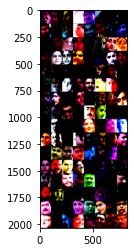

In [14]:
### visualing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  print('img size--',img_batch.size(2))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i, sample_batch in enumerate(dataloader['train']):
  img, label = sample_batch
  print(i, img.size(), label.shape)
  if i==3:
    show_batch(sample_batch)
    break

# Trainer

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    latest_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for img_batch, labels in dataloader[phase]:
                img_batch = img_batch.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img_batch)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_batch.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            latest_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training model

In [19]:
# lr_list = np.random.rand(20)
# lr_list = 10**(-5*lr_list)
# for lr in lr_list:
#   print('***********\tLR =',lr,'\t************')
model = timm.models.efficientnet_b2_pruned(pretrained=True,num_classes=3)
#model = best_model

device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9, nesterov=True)
optimizer = Ranger(model.parameters(), lr= 1)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.3,patience=6,threshold=0.0005)


best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
train Loss: 1.3096 Acc: 0.5003
val Loss: 0.9543 Acc: 0.5372

Epoch 1/39
----------
train Loss: 5.6680 Acc: 0.4942
val Loss: 11509.2171 Acc: 0.5381

Epoch 2/39
----------
train Loss: 2.2464 Acc: 0.4713
val Loss: 0.9296 Acc: 0.5423

Epoch 3/39
----------
train Loss: 0.9445 Acc: 0.5555
val Loss: 0.8165 Acc: 0.6335

Epoch 4/39
----------
train Loss: 0.8942 Acc: 0.5929
val Loss: 1.2119 Acc: 0.5372

Epoch 5/39
----------
train Loss: 0.8628 Acc: 0.6077
val Loss: 0.7917 Acc: 0.6628

Epoch 6/39
----------
train Loss: 0.8146 Acc: 0.6332
val Loss: 0.8314 Acc: 0.6569

Epoch 7/39
----------
train Loss: 0.7848 Acc: 0.6513
val Loss: 0.7021 Acc: 0.6778

Epoch 8/39
----------
train Loss: 0.7692 Acc: 0.6606
val Loss: 0.8842 Acc: 0.5766

Epoch 9/39
----------
train Loss: 0.7591 Acc: 0.6708
val Loss: 0.6826 Acc: 0.7096

Epoch 10/39
----------
train Loss: 0.7538 Acc: 0.6716
val Loss: 0.7473 Acc: 0.6870

Epoch 11/39
----------
train Loss: 0.7322 Acc: 0.6777
val Loss: 0.7065 Acc: 0.6854

# fine tuning


In [0]:
model = best_model
# for param in model.parameters():
#     param.requires_grad = True

device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimiser = Ranger(model.parameters(), lr= 0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.3,patience=6,threshold=0.0005)

In [21]:
new_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5973 Acc: 0.7528
val Loss: 0.7624 Acc: 0.6561

Epoch 1/9
----------
train Loss: 0.5805 Acc: 0.7551
val Loss: 0.5642 Acc: 0.7908

Epoch 2/9
----------
train Loss: 0.5837 Acc: 0.7590
val Loss: 0.5985 Acc: 0.7565

Epoch 3/9
----------
train Loss: 0.5743 Acc: 0.7618
val Loss: 0.5313 Acc: 0.7808

Epoch 4/9
----------
train Loss: 0.5777 Acc: 0.7611
val Loss: 0.5902 Acc: 0.7649

Epoch 5/9
----------
train Loss: 68.3285 Acc: 0.6394
val Loss: 11103.3522 Acc: 0.5356

Epoch 6/9
----------
train Loss: 10.8383 Acc: 0.4546
val Loss: 62604107.9760 Acc: 0.5347

Epoch 7/9
----------
train Loss: 1.8304 Acc: 0.4984
val Loss: 865615832.4342 Acc: 0.5372

Epoch 8/9
----------
train Loss: 0.9987 Acc: 0.5254
val Loss: 2.0171 Acc: 0.5372

Epoch 9/9
----------
train Loss: 0.9800 Acc: 0.5233
val Loss: 26306608093781.0391 Acc: 0.5364

Training complete in 15m 13s
Best val Acc: 0.790795


# Prediction on test 

In [0]:
label_decoding={0:'YOUNG',1:'MIDDLE',2:'OLD'}

In [0]:
prediction = torch.tensor([],dtype=torch.int64)
# prediction = prediction.to(device)
for inputs, labels in dataloader['test']:
            # inputs = inputs.to(device)
            # labels = labels.to(device)
            new_model.to('cpu')
            
            outputs = new_model(inputs)
            _, preds = torch.max(outputs, 1)
            #print(type(preds),preds.shape,preds.dtype,preds.device)
            prediction = torch.cat((prediction,preds),0)
            #print(prediction.shape,prediction.device)
print(prediction.shape)

In [0]:
sub_csv = test_csv.copy()
#prediction = prediction.to('cpu')
print(prediction.device)
for i in range(len(prediction)):
  sub_csv.Class[i] = label_decoding[int(prediction[i])]

In [0]:
test_csv.head()

In [0]:
sub_csv.head()

In [0]:
sub_csv.to_csv('/content/sample_submission_sDO3m7O.csv',index=False)

# TTA

In [25]:
!git clone https://github.com/qubvel/ttach.git

Cloning into 'ttach'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 90 (delta 45), reused 54 (delta 21), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [0]:
up_model = timm.models.efficientnet_b0()
up_model = torch.load('/content/effb0_imp2_whole')

In [0]:
from ttach import *
test_tf = Compose([HorizontalFlip()])
tta_model = ClassificationTTAWrapper(up_model,test_tf,merge_mode='mean')

In [42]:
prediction = torch.tensor([],dtype=torch.int64)
prediction = prediction.to(device)
for inputs, labels in dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            tta_model.to(device)
            
            outputs = tta_model(inputs)
            _, preds = torch.max(outputs, 1)
            #print(type(preds),preds.shape,preds.dtype,preds.device)
            prediction = torch.cat((prediction,preds),0)
            #print(prediction.shape,prediction.device)
print(prediction.shape)

torch.Size([6636])


In [43]:
sub_csv = test_csv.copy()
#prediction = prediction.to('cpu')
print(prediction.device)
for i in range(len(prediction)):
  sub_csv.Class[i] = label_decoding[int(prediction[i])]

cuda:0


In [44]:
sub_csv.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,YOUNG
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [0]:
sub_csv.to_csv('/content/sample_submission_sDO3m7O.csv',index=False)